In [147]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math

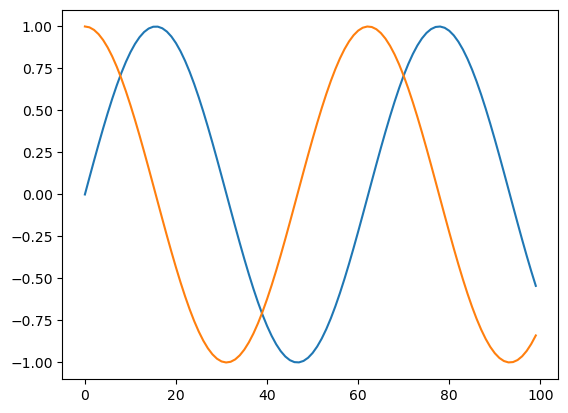

In [148]:
num_steps = 100
inputs = torch.stack(
    [
        torch.sin(torch.linspace(0, 10, num_steps)),
        torch.cos(torch.linspace(0, 10, num_steps)),
    ]
).T  # Shape [time_steps, num_inputs]

plt.plot(np.array(inputs))

In [149]:
# add a batch dimension to inputs
inputs = inputs.unsqueeze(0)

In [150]:
d_model = 2
rmax = 0.9
rmin = 0.4

u1 = torch.rand(d_model)
u2 = torch.rand(d_model)

nu_log = torch.log(-0.5 * torch.log(u1 * (rmax + rmin) * (rmax - rmin) + rmin**2))
theta_log = torch.log(2 * math.pi * u2)

A = torch.exp(-torch.exp(nu_log) + 1j * torch.exp(theta_log))
print(A)
nu_log, theta_log

tensor([0.7473-0.0638j, 0.2745+0.4730j])


(tensor([-1.2462, -0.5050]), tensor([1.8242, 0.0441]))

In [151]:
input_dim = 2
B_re = torch.rand(d_model, input_dim) / math.sqrt(2 * input_dim)
B_im = torch.rand(d_model, input_dim) / math.sqrt(2 * input_dim)
B = B_re + 1j * B_im
print(B)
(b, L, d) = inputs.shape
b, L, d, B.shape

tensor([[0.0993+0.2083j, 0.1198+0.2941j],
        [0.1905+0.2991j, 0.1913+0.2799j]])


(1, 100, 2, torch.Size([2, 2]))

In [152]:
from einops import einsum

inp = torch.tensor(inputs, dtype=torch.complex64)
u = einsum(inp, B, "b l d, h d -> b l h")
u.shape

/tmp/ipykernel_2435131/1937836590.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(inputs,dtype=torch.complex64)


torch.Size([1, 100, 2])

In [153]:
x_rec = torch.zeros((b, L, d_model), dtype=torch.complex64)
for i in range(L):
    x_rec[:, i] = A * x_rec[:, i - 1] + u[:, i]  # ein

In [159]:
t = torch.arange(L)
H = A[:, None] ** t
h_f = torch.fft.fft(H, n=2 * L, dim=1)
h_f.shape

torch.Size([2, 200])

In [157]:
u_f = torch.fft.fft(u, n=2 * L, dim=1)  # (B H L)
u_f.shape

torch.Size([1, 200, 2])

In [160]:
(u_f * h_f.T).shape

torch.Size([1, 200, 2])

In [169]:
x_k = torch.fft.ifft(u_f * h_f.T, n=2 * L, dim=1)[:, :L]  # (B H L)
x_k.shape

torch.Size([1, 100, 2])

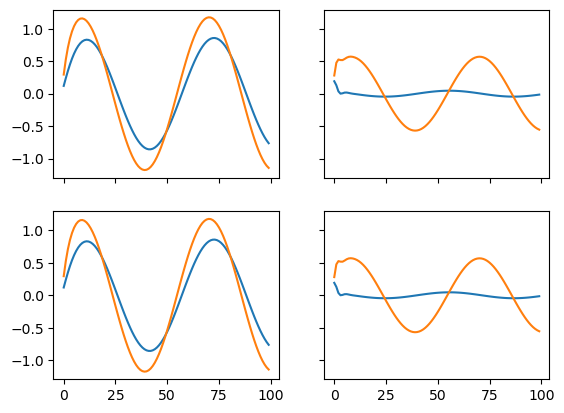

In [171]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
for i in range(2):
    ax[0, i].plot(x_rec[0, :, i].real)
    ax[0, i].plot(x_rec[0, :, i].imag)

    ax[1, i].plot(x_k[0, :, i].real)
    ax[1, i].plot(x_k[0, :, i].imag)

In [181]:
# testing the LRU model now
import sys

%load_ext autoreload
%autoreload 2
sys.path.append("/om2/user/ostrow/NN_delay_embeddings/nn_delay_embeddings")
from src.models import LRUBlock

In [182]:
lru = LRUBlock(2, 10, 2)

In [198]:
x, y = lru(inputs)
x_rnn, y_rnn = lru(inputs, rnn=True)

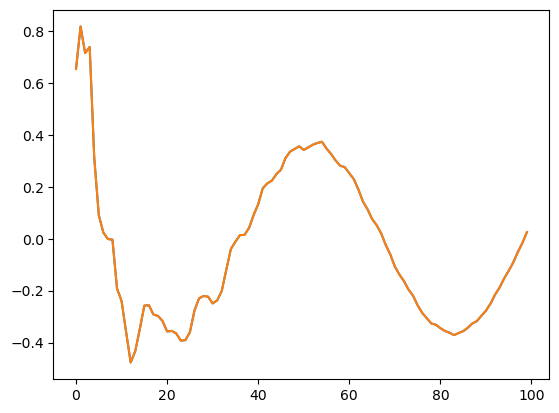

In [200]:
# plot y_rnn vs y
plt.plot(y[0, :, 0].detach().numpy())
plt.plot(y_rnn[0, :, 0].detach().numpy())

/om2/user/ostrow/anaconda/envs/nn_delays/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/om2/user/ostrow/anaconda/envs/nn_delays/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


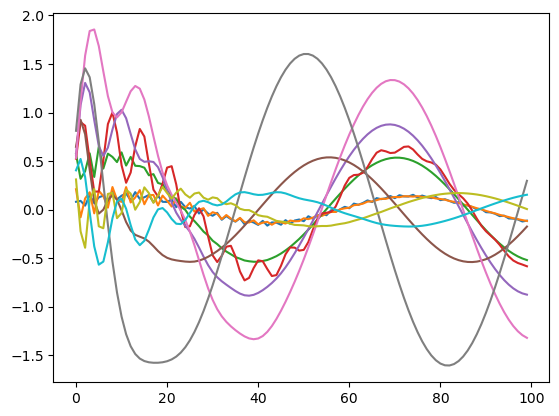

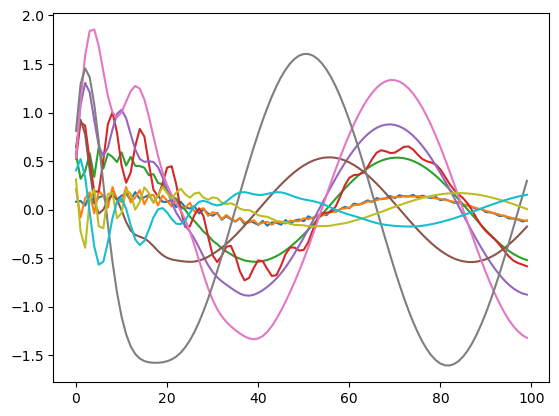

In [203]:
# plot xs
plt.plot(x[0, :, :].detach().numpy())
plt.figure()
plt.plot(x_rnn[0, :, :].detach().numpy())